In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy
from scipy.spatial.distance import pdist, squareform
import sklearn
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.model_selection import KFold
import tqdm
import requests
import time

In [2]:
def compute_rwr_original_sparse(ppi_files,restart_prob,ngene,nets):
    ''' 
    - ppi_files: list of network file paths
    - restart_prob: RWR restart probability
    - ngene: number of genes

    walks[i,:,:]: each column is the stationary distribution of a node
    '''
    n_file = len(ppi_files)
    e = np.ones(ngene)
    I = np.eye(ngene)
    walks = np.zeros((n_file,ngene,ngene))
    for i in range(n_file):
        A = nets[i,:,:]
        d = A @ e
        P = A / d # transition matrix
        W = (I - (1 - restart_prob) * P)
        W = np.linalg.inv(W)
        W = W * restart_prob 
        walks[i,:,:] = W
    return walks

In [3]:
# there are subtle differences between matlab implementation and python implementation.
# It's caused by after RWR, there are some values that are extremely small, 
# for example, in network 6, [1825,943], its value is 1e-17 ish, after taking log, the log becomes -38
# these differences accumulated and as a result, the eigenvalues become different.
# After filtering out the extreme numbers in matlab code, the two results become the same.
def svd_embed_sparse_func(walks, ngene, embed_dim):
    n_net = walks.shape[0]
    mat = np.zeros((ngene,ngene))
    W_updated = np.zeros_like(walks)
    for i in range(n_net):
        W = walks[i,:,:]
        W[W<=1e-8] = 0
        W = np.log(W, where = W > 1e-8)
        W_updated[i,:,:] = W
        tmp = W.T @ W
        mat = mat + tmp
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(mat,k=embed_dim)
    x = np.diag(np.sqrt(np.sqrt(eigenvalues))) @ eigenvectors.T
    return np.real(x)

In [4]:
def augment_graph(nets, ngene, gene_clusters, mustlink_weight, cannotlink_weight):
    '''
    - nets: original adjacency matrices directly read from PPI files
    - gene_clusters: (num_clusers, num_genes), binary matrix indicating which gene belongs to which clusters
    '''
    n_nets = nets.shape[0]
    n_clusters = gene_clusters.shape[0]
    augmented = np.zeros((n_nets,(ngene+n_clusters),(ngene+n_clusters)))
    for i in range(n_nets):
        A = nets[i,:,:]
        A_block = np.block([[A,mustlink_weight*gene_clusters.T],[mustlink_weight*gene_clusters,cannotlink_weight*np.ones((n_clusters,n_clusters))]])
        np.fill_diagonal(A_block,0)
        zero_rows = np.all(np.absolute(A_block) == 0, axis=1)
        diag_indices = np.arange(ngene+n_clusters)
        A_block[diag_indices[zero_rows], diag_indices[zero_rows]] = 1
        augmented[i,:,:] = A_block
    return augmented

In [5]:
def augmented_RWR(augmented_nets, restart_prob):
    n_nets = augmented_nets.shape[0]
    n_nodes = augmented_nets.shape[1]
    augmented_walks = np.zeros((n_nets,n_nodes,n_nodes))
    e = np.ones(n_nodes)
    for i in range(n_nets):
        A = augmented_nets[i,:,:]
        d = np.absolute(A) @ e
        L = np.diag(d) - (1-restart_prob)*A
        L_inv = np.linalg.inv(L)
        W = restart_prob*(np.diag(d) @ L_inv)
        augmented_walks[i,:,:] = W
    return augmented_walks


In [6]:
def augmented_SVD_with_cannolink(aug_walks, embed_dim):
    n_net = aug_walks.shape[0]
    n_node = aug_walks.shape[1]
    mat = np.zeros((n_node,n_node))
    W_updated = np.zeros_like(aug_walks)
    for i in range(n_net):
        W = aug_walks[i,:,:]
        min_entry = W.min()
        if min_entry > 0:
            min_entry = 0.0
        W = W - min_entry
        W[W<=1e-8] = 0
        W = np.log(W, where = W > 1e-8)
        W_updated[i,:,:] = W
        tmp = W.T @ W
        mat = mat + tmp
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(mat,k=embed_dim)
    x = np.diag(np.sqrt(np.sqrt(eigenvalues))) @ eigenvectors.T
    return np.real(x)

In [7]:
def get_knn_ind(embed,train_anno):
    '''
    parameters:
    - embed: (dim, num_gene), protein embeddings
    - train_anno: annotations for training proteins
    output:
    dist_mat: n_gene x n_gene
    sorted_ind: ngene x (ngene-1), top n labels
    '''
    n_gene = train_anno.shape[1]
    train_idx = np.where(sum(train_anno)>0)[0]
    dist_mat = squareform(pdist(embed.T))
    dist_mat = dist_mat[:n_gene,:n_gene] # symmetrical
    np.fill_diagonal(dist_mat, 1e8)
    sorted_ind = np.argsort(dist_mat, axis=1)
    
    return dist_mat, sorted_ind


In [8]:
def majority_vote(dist_mat, knn_mat, train_anno, test_anno,k, weighted=True):
    '''
    parameters:
    - dist_mat: n_gene x n_gene
    - knn_mat: ngene x (ngene-1), sorted labels
    - train_anno: n_label x n_gene
    - test_anno: n_label x n_gene
    - k: number of nearest neighbors
    - weighted: boolean, whether doing weighted majority vote or not
    output:
    - final_scores: n_label x n_test, normalized scores of each label
    - num_voters: vector of numbers of voting nodes
    '''
    train_idx = np.where(sum(train_anno)>0)[0]
    test_idx = np.where(sum(test_anno)>0)[0]
    final_scores = np.zeros((train_anno.shape[0],len(test_idx)))
    num_voters = []
    updated_voters = []
    c = 0
    for index, i in enumerate(test_idx):
        nn = knn_mat[i,:k]
        nn_labeled = nn[np.isin(nn, train_idx)] 
        if len(nn_labeled) == 0: # if within the first k neighbors, no neighbor is labeled, then use the nearest neighbor with label
            voting_node = knn_mat[i,:][np.isin(knn_mat[i,:], train_idx)][0]
            scores = np.array(train_anno[:,voting_node])
            scores = scores / sum(scores)
            num_voters.append(len(nn_labeled))
            tmp = [voting_node]
            updated_voters.append(tmp)
        else:
            votes = np.array(train_anno[:,nn_labeled])
            if weighted:
                d = dist_mat[i,nn_labeled]
                d = d[np.nonzero(d)]
                votes = np.array(train_anno[:,nn_labeled[np.nonzero(d)]])
                tmp = nn_labeled[np.nonzero(d)]
                updated_voters.append(tmp)
                num_voters.append(len(d))
                if len(d) == 0:
                    c += 1
                    voting_node = np.random.choice(train_idx)
                    scores = np.array(train_anno[:,voting_node])
                    scores = scores / sum(scores)
                else:
                    weights = 1 / d
                    scores = votes @ weights.T
                    scores = scores / sum(scores)
            else:
                num_voters.append(len(nn_labeled))
                updated_voters.append(nn_labeled)
                scores = np.sum(votes,axis=1)
                scores = scores / sum(scores)
        
        final_scores[:,index] = np.squeeze(scores)
    # print(c)
    return final_scores, num_voters,updated_voters


In [9]:
def acc_top1_pred(test_scores, test_anno):
    '''
    for each test gene, find the label with the highest predicted score, use it as the predicted label
    accuracy is defined as (#predicted label in test true labels) / (#test genes)
    problems: if there's a tie, the one with smaller index will be used
    parameters:
    - test_scores: n_label x n_test
    - test_anno: n_label x n_gene
    output:
    - acc: accuracy score
    '''
    test_idx = np.where(sum(test_anno)>0)[0]
    zero_idx = np.where(np.sum(test_scores,axis=0)==0)[0]
    mask = np.ones(len(test_idx), dtype=bool)
    mask[zero_idx] = False
    test_anno = test_anno[:,test_idx] # n_label x n_test
    sorted_index = np.argsort(-1*test_scores,axis=0) # n_label x n_test, with row 0 the highest predicted label for each gene
    true_pred = test_anno[sorted_index[0,:], np.arange(test_anno.shape[1])]
    true_pred = true_pred[mask]
    acc = np.mean(true_pred)
    return acc,true_pred
    

In [10]:
def f1_auprc_pred(test_scores, test_anno,top_n):
    '''
    for each test gene, find the labels with the top_n highest predicted scores, use them as the predicted labels
    f1 is defined as 2*TP / 2*TP + FP + FN
    probelms: if there's a tie, the one with smaller index will be used, only top n predictions will be considered, it will increase the number of FN
    parameters:
    - test_scores: n_label x n_test
    - test_anno: n_label x n_gene
    - top_n: int, the number of labels to be predicted
    output:
    - acc: accuracy score
    '''
    test_idx = np.where(sum(test_anno)>0)[0]
    zero_idx = np.where(np.sum(test_scores,axis=0)==0)[0]

    mask = np.ones(len(test_idx), dtype=bool)
    mask[zero_idx] = False
    test_anno = test_anno[:,test_idx] # n_label x n_test
    
    test_anno = test_anno[:,mask]
    test_scores = test_scores[:,mask]
    sorted_index = np.argsort(-1*test_scores,axis=0) # n_label x n_test, with row 0 the highest predicted label for each gene
    top_ind = sorted_index[:top_n,:].flatten()
    pred = np.zeros_like(test_anno)
    cols = np.tile(np.arange(test_anno.shape[1]), top_n)
    pred[top_ind, cols] = 1
    f1 = sklearn.metrics.f1_score(test_anno.flatten(),pred.flatten())
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(test_anno.flatten(), pred.flatten())
    auprc = sklearn.metrics.auc(recall, precision)
    return f1, auprc
    


In [11]:
'''
for each augmented node, randomly choose a fixed number of nodes to connect to
the number of genes that each augmented node connects to are the same except for the last one
'''
def random_split_vector(train_anno,n_gene, num_sub_vectors,seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    input_vector = np.where(sum(train_anno)>0)[0]

    if num_sub_vectors <= 0 or num_sub_vectors > len(input_vector):
        raise ValueError("Invalid number of sub-vectors")
    
    shuffled_vector = np.random.permutation(input_vector)
    sub_vector_size = len(shuffled_vector) // num_sub_vectors
    
    group_matrix = np.zeros((num_sub_vectors, len(input_vector)), dtype=int)
    res_matrix = np.zeros((num_sub_vectors, n_gene), dtype=int)
    
    start_index = 0
    for i in range(num_sub_vectors):
        end_index = start_index + sub_vector_size
        
        if i == num_sub_vectors - 1:
            end_index = len(shuffled_vector)
        
        selected_indices = shuffled_vector[start_index:end_index]
        
        group_matrix[i, np.isin(shuffled_vector, selected_indices)] = 1
        start_index = end_index
    
    res_matrix[:,shuffled_vector] = group_matrix
    
    return res_matrix

Synthetic Graph Generation

In [12]:
def generate_label_matrix(communities,n_node):
    label_matrix = np.zeros((len(communities),n_node))
    for idx, comm in enumerate(communities):
        node_id = list(comm)
        label_matrix[idx,node_id] = 1
    return label_matrix

In [13]:
def add_edges_biased(G: nx.Graph,subset,p_intra = None,p_inter = None):
    '''
    Add edges to G inplace so that nodes inside subset get more internal edges and less external edges.

    Parameters
    ----------
    G : nx.Graph or nx.DiGraph
        Graph that already contains all nodes. (Existing edges stay.)
    subset : iterable
        Collection of node labels you want to knit together.
    p_intra : float
        Probability of adding an edge between 2 subset nodes.
    p_inter : float
        Probability of adding an edge between a subset node and any node outside the subset.
    seed : int | None
        Optional RNG seed for reproducibility.
    '''
    
    subset = set(subset)
    all_nodes = list(G.nodes)

    for u in subset:
        for v in subset: # within cluster
            if u < v and not G.has_edge(u, v):
                if random.random() <= p_intra:
                    G.add_edge(u, v)

        for v in all_nodes: # outside of cluster
            if v not in subset and not G.has_edge(u, v):
                if random.random() <= p_inter:
                    G.add_edge(u, v)


In [14]:
def mask_symmetric_ones(A, frac=None, seed=None, keep_diagonal=True):
    '''
    randomly remove some edges, return the symetrical adjacency matrix

    Parameters
    ----------
    A : numpy ndarray
        Adjacency matrix of the original graph.
    frac : float
        Percentage of edges to be removed.
    seed : int | None
        Optional RNG seed for reproducibility.
    keep_diagonal : bool 
        Default True, the diagonal values will be kept. Otherwise repalce to all 0.

    '''
    rng = np.random.default_rng(seed)
    r, c = np.triu_indices_from(A, k=1) # upper triangle
    ones_mask = A[r, c] == 1 
    edge_pos = np.where(ones_mask)[0] 

    num_edge_remove = int(np.round(frac * edge_pos.size))
    if num_edge_remove == 0:
        return A.copy()

    chosen = rng.choice(edge_pos, size=num_edge_remove, replace=False)

    A_masked = A.copy()
    rows, cols = r[chosen], c[chosen]
    A_masked[rows, cols] = 0
    A_masked[cols, rows] = 0

    # if not keep_diagonal:
    np.fill_diagonal(A_masked, 0)

    zero_rows = np.all(A_masked == 0, axis=1)
    diag_indices = np.arange(A_masked.shape[0])
    A_masked[diag_indices[zero_rows], diag_indices[zero_rows]] = 1

    return A_masked


In [15]:
def rewire_graph(ori_A,communities,percentage,p_intra=None, p_inter=None, p_disconnect=None):
    '''
    Based on the base graph and known community information, randomly generate one sparse noisy graph

    Parameters
    ----------
    ori_A : numpy ndarray
        Adjacency matrix of the base graph.
    communities : iterable
        Collection of lists of node ids.
    percentage : float
        Percentage of nodes per community you want to remain closely clustered
    p_intra : float
        Probability of adding an edge between 2 subset nodes.
    p_inter : float
        Probability of adding an edge between a subset node and any node outside the subset.
    p_disconnect: float (optional) UPDATE: removed
        Probability of adding an edge between all disconnected nodes after all communities formed.
    '''

    G = nx.Graph()
    G.add_nodes_from(range(ori_A.shape[0]))
    for idx, comm in enumerate(communities):
        node_id = list(comm)
        k = int(len(node_id) * percentage) 
        sampled = random.sample(node_id, k)
        add_edges_biased(G, sampled, p_intra=p_intra, p_inter=p_inter)
    G.remove_edges_from(nx.selfloop_edges(G))
    # disconnected_nodes = list(nx.isolates(G))
    # add_edges_biased(G, disconnected_nodes, p_intra=p_disconnect, p_inter=p_disconnect)
    return G

In [16]:
def generate_base_graph(n,tau1,tau2,mu,avg_degree,max_degree,min_community,max_community,seed):
    while True:
        try:
            G_multi = nx.LFR_benchmark_graph(
                n=n,tau1=tau1,tau2=tau2,mu=mu,average_degree=avg_degree,max_degree=max_degree,min_community=min_community,max_community=max_community,seed=seed
            )
            break
        except Exception as e:
            print(f"Failed with error: {e}. Retrying...")

    G = nx.Graph(G_multi)
    G.remove_edges_from(nx.selfloop_edges(G))
    print("Simple graph info: ",G)
    communities = {frozenset(G.nodes[v]["community"]) for v in G}
    print("number of communities: ",len(communities))
    labels = generate_label_matrix(communities,1000)
    kf = KFold(n_splits=5, shuffle=True)
    folds = []
    for train_idx, test_idx in kf.split(labels.T):
        folds.append((train_idx, test_idx))
    (largest_node, largest_degree) = max(dict(G.degree()).items(), key=lambda item: item[1])
    print("largest node id, largest node degree",(largest_node, largest_degree))
    return G, labels, folds, communities


In [17]:
def generate_syn_graph(G,communities, with_base, num_graph,percentage_list,p_intra_list,p_inter_list,p_disconnect_list):
    '''
    Parameters
    ----------
    G : nx.Graph
        The base graph 
    output
    ------
    graphs: list
        base graph along with generated random graphs
    '''

    A = nx.adjacency_matrix(G)
    A = A.toarray()
    if with_base:
        syn_nets = np.zeros((num_graph+1,A.shape[0],A.shape[0]))
        syn_nets[0,:,:] = A
        graphs = [G]
    else:
        syn_nets = np.zeros((num_graph,A.shape[0],A.shape[0]))
        graphs = []
    
    for i in range(num_graph):
        tmp_g = rewire_graph(A,communities,percentage_list[i],p_intra=p_intra_list[i], p_inter=p_inter_list[i],p_disconnect=p_disconnect_list[i])
        print("generated graph: ",tmp_g)
        graphs.append(tmp_g)
        tmp_A = nx.adjacency_matrix(tmp_g)
        tmp_A = tmp_A.toarray()
        diag_idx = np.where(np.sum(tmp_A,axis=0)==0)[0]
        tmp_A[diag_idx,diag_idx] = 1
        if with_base:
            syn_nets[(i+1),:,:] = tmp_A
        else:
            syn_nets[(i),:,:] = tmp_A

    return graphs, syn_nets



In [18]:
def run_synthetic_pipeline(syn_nets, labels, folds):
    mu_acc_res = []
    rand_acc_res = []
    syn_files = list(range(syn_nets.shape[0]))
    for i in range(len(folds)):
        print("fold: ", i+1)
        syn_train_anno = np.copy(labels)
        syn_train_anno[:,folds[i][1]] = 0
        syn_test_anno = np.copy(labels)
        syn_test_anno[:,folds[i][0]] = 0
        syn_nets_mu = syn_nets.copy()
        syn_walks = compute_rwr_original_sparse(syn_files,0.5,syn_nets.shape[1],syn_nets_mu)
        syn_x = svd_embed_sparse_func(syn_walks, syn_nets.shape[1], 400)
        syn_mu_dist_mat, syn_mu_knn = get_knn_ind(syn_x,syn_train_anno)
        syn_mu_scores, syn_mu_num_voters,syn_mu_voters = majority_vote(syn_mu_dist_mat, syn_mu_knn, syn_train_anno, syn_test_anno,10)
        syn_mu_acc,syn_mu_correct_pred_ind = acc_top1_pred(syn_mu_scores, syn_test_anno)
        mu_acc_res.append(syn_mu_acc)
        
        syn_nets_rand = syn_nets.copy()
        syn_rand_cluster = random_split_vector(syn_train_anno,syn_nets.shape[1], 15,seed=None)
        syn_rand_graph = augment_graph(syn_nets_rand, syn_nets.shape[1], syn_rand_cluster, 1, -1)
        syn_rand_rwr_res = augmented_RWR(syn_rand_graph, 0.5)
        syn_rand_x = augmented_SVD_with_cannolink(syn_rand_rwr_res, 400)
        syn_rand_dist_mat, syn_rand_knn = get_knn_ind(syn_rand_x,syn_train_anno)
        syn_rand_scores, syn_rand_num_voters,rand_voters = majority_vote(syn_rand_dist_mat, syn_rand_knn, syn_train_anno, syn_test_anno,10, weighted=True)
        syn_rand_acc, syn_rand_correct_pred_ind = acc_top1_pred(syn_rand_scores, syn_test_anno)
        rand_acc_res.append(syn_rand_acc)
    return mu_acc_res, rand_acc_res


In [19]:
def replicate(num_rep,param_dict1,param_dict2,with_base=True):
    ''' 
    within one replicate: one base graph, one label info and fold split, one set of augmented graphs
    across replicates: different base graphs generated using the same set of parameters, label and fold split according to its particular base graph
    '''
    mu_rep_list = []
    rand_rep_list = []
    for rep in range(num_rep):
        print("replicate number: ",rep)
        base_G, labels, folds, communities = generate_base_graph(**param_dict1)
        graphs, syn_nets = generate_syn_graph(base_G,communities,with_base,**param_dict2)
        mu_res, rand_res = run_synthetic_pipeline(syn_nets, labels, folds)
        mu_rep_list.append(mu_res)
        rand_rep_list.append(rand_res)
    return mu_rep_list, rand_rep_list


In [32]:
def averaged_perf(rep,mu_rep_list,rand_rep_list):
    mu_mean_list = []
    mu_std_list = []
    rand_mean_list = []
    rand_std_list = []
    for i in range(rep):
        mu_mean_list.append(np.mean(mu_rep_list[i]))
        mu_std_list.append(np.std(mu_rep_list[i]))
        rand_mean_list.append(np.mean(rand_rep_list[i]))
        rand_std_list.append(np.std(rand_rep_list[i]))
    print("Mashup averaged accuracy: ",np.mean(mu_mean_list))
    print("Mashup averaged std: ",np.mean(mu_std_list))
    print("REPEL averaged accuracy: ",np.mean(rand_mean_list))
    print("REPEL averaged std: ",np.mean(rand_std_list))

illustration

In [21]:
params_base_model = {
    'n'                : 120,           # desired size
    'tau1'             : 2.5,
    'tau2'             : 1.5,           # power-law exponent for degree distribution (typically 2 < tau < 3), community size distribution
    'mu'               : 0.08,          # percentage % of each node’s links leave its community, 0.1–0.3 is realistic for biological networks
    'avg_degree'       : 7,             # typical PPI mean degree, average degree
    'max_degree'       : None,          # hubs
    'min_community'    : 33,            # typical small community sizes (e.g., protein complexes)
    'max_community'    : 50,            # upper bound for community sizes
    'seed'             : 42
}

params_syn_model = {
    'num_graph'        : 3,
    'percentage_list'  :[0.2,0.2,0.2],
    'p_intra_list'     :[0.005,0.005,0.005] ,
    'p_inter_list'     :[0.005,0.005,0.005] ,
    'p_disconnect_list':[0.005,0.005,0.005] # UPDATE: not necessary
}

In [22]:
base_G, labels, folds, communities = generate_base_graph(**params_base_model) 
graphs, syn_nets = generate_syn_graph(base_G,communities,with_base=True,**params_syn_model)

Simple graph info:  Graph with 120 nodes and 479 edges
number of communities:  3
largest node id, largest node degree (50, 45)
generated graph:  Graph with 120 nodes and 14 edges
generated graph:  Graph with 120 nodes and 16 edges
generated graph:  Graph with 120 nodes and 14 edges


In [23]:
community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i
colors = [community_map[node] for node in base_G.nodes()]

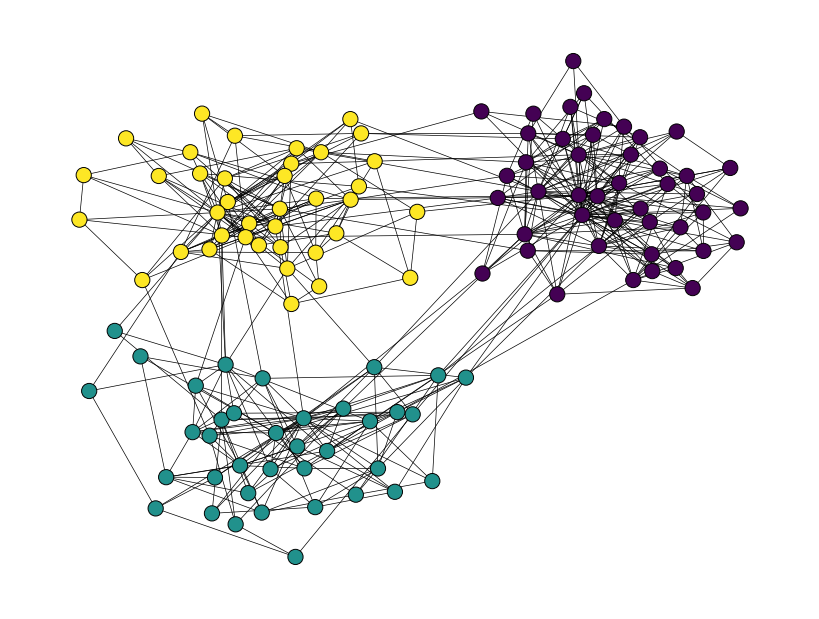

In [24]:
# base graph
plt.figure(figsize=(8,6))
pos = nx.spring_layout(base_G,k=0.25,seed=42)
nx.draw(base_G,pos,node_color=colors,edge_color='black',node_size=120,edgecolors='black',linewidths=0.7,width=0.5 )
# plt.savefig("base.png",dpi=300,bbox_inches='tight', pad_inches=0.2)
plt.show()


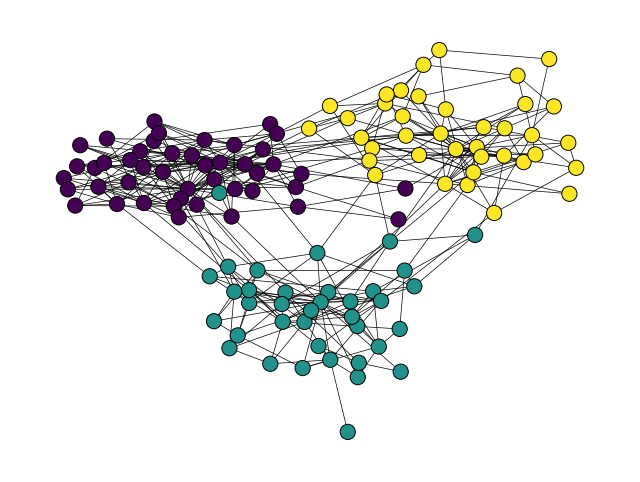

In [25]:
random.seed()
all_edges = base_G.edges()
removed_edges = [e for e in all_edges if random.random() <= 0.2]

G_mode = base_G.copy()
G_mode.remove_edges_from(removed_edges)

# pos = nx.spring_layout(base_G,k=0.25,seed=42)
pos = nx.spring_layout(G_mode,k=0.25)
plt.figure(figsize=(8,6))
plt.axis('off')

nx.draw(G_mode,pos,node_color=colors,edge_color='black',node_size=120,edgecolors='black',linewidths=0.7,width=0.5 )
# plt.savefig("removed20.png",dpi=300,bbox_inches='tight', pad_inches=0.2)
plt.show()

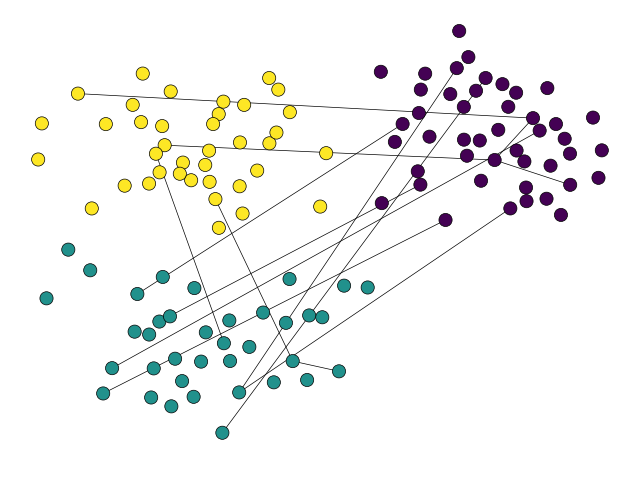

In [26]:
pos = nx.spring_layout(base_G,k=0.25,seed=42)
plt.figure(figsize=(8,6))
plt.axis('off')

nx.draw_networkx_nodes(base_G,pos, node_color=colors,node_size=90,edgecolors='black',linewidths=0.5)
nx.draw_networkx_edges(graphs[3],pos,edge_color='black',width=0.5)
plt.show()

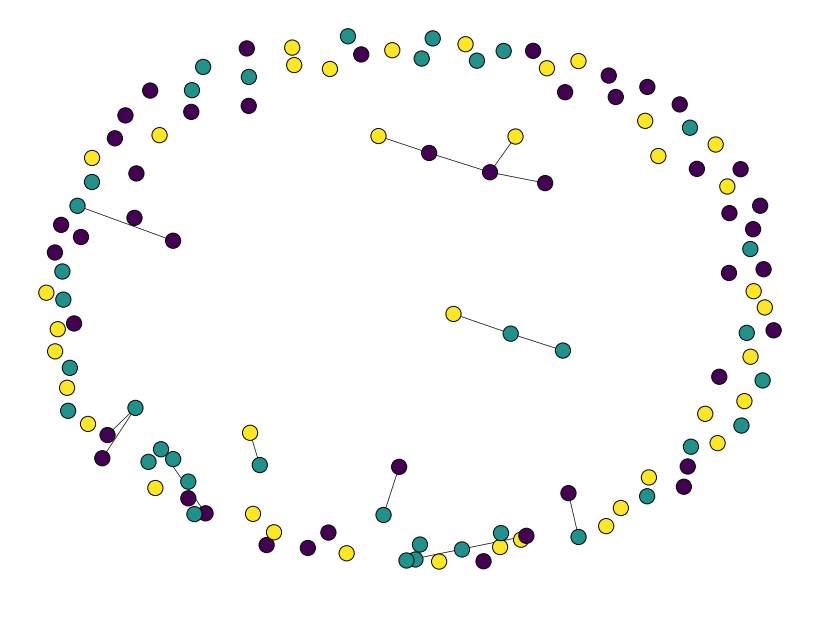

In [27]:
plt.figure(figsize=(8,6))
pos = nx.spring_layout(graphs[3],k=0.35,seed=42)
nx.draw(graphs[3],pos,node_color=colors,edge_color='black',node_size=120,edgecolors='black',linewidths=0.7,width=0.5 )
plt.show()

Simulation tests

In [28]:
params_base = {
    'n'                : 1000,           # desired size
    'tau1'             : 2.5,
    'tau2'             : 1.5,            # power-law exponent for degree distribution (typically 2 < tau < 3), community size distribution
    'mu'               : 0.15,           # percentage % of each node’s links leave its community, 0.1–0.3 is realistic for biological networks
    'avg_degree'       : 20,             # typical PPI mean degree, average degree
    'max_degree'       : 100,            # hubs
    'min_community'    : 15,             # typical small community sizes (e.g., protein complexes)
    'max_community'    : 100,            # upper bound for community sizes
    'seed'             : None
}
params_config1 = {
    'num_graph'        : 3,
    'percentage_list'  :[0.8,0.8,0.8],
    'p_intra_list'     :[0.2,0.2,0.2],
    'p_inter_list'     :[0.005,0.005,0.005],
    'p_disconnect_list':[0.005,0.005,0.005]
}

In [29]:
mu_rep_config1, rand_rep_config1 = replicate(10,params_base,params_config1,with_base=True)

replicate number:  0
Simple graph info:  Graph with 1000 nodes and 12426 edges
number of communities:  29
largest node id, largest node degree (495, 100)
generated graph:  Graph with 1000 nodes and 6668 edges
generated graph:  Graph with 1000 nodes and 6704 edges
generated graph:  Graph with 1000 nodes and 6688 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  1
Simple graph info:  Graph with 1000 nodes and 12296 edges
number of communities:  25
largest node id, largest node degree (963, 101)
generated graph:  Graph with 1000 nodes and 6821 edges
generated graph:  Graph with 1000 nodes and 6788 edges
generated graph:  Graph with 1000 nodes and 6772 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  2
Simple graph info:  Graph with 1000 nodes and 12373 edges
number of communities:  27
largest node id, largest node degree (529, 100)
generated graph:  Graph with 1000 nodes and 6829 edges
generated graph:  Graph with 1000 nodes and 6971 edges
generate

In [33]:
averaged_perf(10,mu_rep_config1,rand_rep_config1)

Mashup averaged accuracy:  0.9033999999999999
Mashup averaged std:  0.0809162402796464
REPEL averaged accuracy:  0.9818999999999999
REPEL averaged std:  0.01059891110126494


In [34]:
params_config2 = {
    'num_graph'        : 3,
    'percentage_list'  :[0.8,0.6,0.4],
    'p_intra_list'     :[0.2,0.2,0.2],
    'p_inter_list'     :[0.005,0.005,0.005],
    'p_disconnect_list':[0.005,0.005,0.005]
}

In [35]:
mu_rep_config2, rand_rep_config2 = replicate(10,params_base,params_config2,with_base=True)

replicate number:  0
Simple graph info:  Graph with 1000 nodes and 13072 edges
number of communities:  26
largest node id, largest node degree (228, 97)
generated graph:  Graph with 1000 nodes and 7095 edges
generated graph:  Graph with 1000 nodes and 4729 edges
generated graph:  Graph with 1000 nodes and 2704 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  1
Simple graph info:  Graph with 1000 nodes and 12571 edges
number of communities:  28
largest node id, largest node degree (668, 106)
generated graph:  Graph with 1000 nodes and 6721 edges
generated graph:  Graph with 1000 nodes and 4460 edges
generated graph:  Graph with 1000 nodes and 2633 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  2
Simple graph info:  Graph with 1000 nodes and 12421 edges
number of communities:  25
largest node id, largest node degree (532, 103)
generated graph:  Graph with 1000 nodes and 6850 edges
generated graph:  Graph with 1000 nodes and 4622 edges
generated

In [36]:
averaged_perf(10,mu_rep_config2,rand_rep_config2)

Mashup averaged accuracy:  0.6974
Mashup averaged std:  0.23829179083548707
REPEL averaged accuracy:  0.9555999999999999
REPEL averaged std:  0.014764818518770493


In [39]:
params_config3 = {
    'num_graph'        : 3,
    'percentage_list'  :[0.2,0.2,0.2],
    'p_intra_list'     :[0.005,0.005,0.005],
    'p_inter_list'     :[0.005,0.005,0.005],
    'p_disconnect_list':[0.005,0.005,0.005]
}

In [41]:
mu_rep_config3, rand_rep_config3 = replicate(10,params_base,params_config3,with_base=True)


replicate number:  0
Simple graph info:  Graph with 1000 nodes and 12558 edges
number of communities:  24
largest node id, largest node degree (87, 99)
generated graph:  Graph with 1000 nodes and 898 edges
generated graph:  Graph with 1000 nodes and 957 edges
generated graph:  Graph with 1000 nodes and 1000 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  1
Simple graph info:  Graph with 1000 nodes and 12669 edges
number of communities:  24
largest node id, largest node degree (193, 100)
generated graph:  Graph with 1000 nodes and 941 edges
generated graph:  Graph with 1000 nodes and 934 edges
generated graph:  Graph with 1000 nodes and 969 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  2
Simple graph info:  Graph with 1000 nodes and 12282 edges
number of communities:  29
largest node id, largest node degree (563, 104)
generated graph:  Graph with 1000 nodes and 886 edges
generated graph:  Graph with 1000 nodes and 941 edges
generated graph: 

In [42]:
averaged_perf(10,mu_rep_config3,rand_rep_config3)

Mashup averaged accuracy:  0.22089999999999996
Mashup averaged std:  0.14733672314091611
REPEL averaged accuracy:  0.8449
REPEL averaged std:  0.03484276517947227


In [43]:
params_config4 = {
    'num_graph'        : 1,
    'percentage_list'  :[0.2],
    'p_intra_list'     :[0.005],
    'p_inter_list'     :[0.005],
    'p_disconnect_list':[0.005]
}

In [44]:
mu_rep_config4, rand_rep_config4 = replicate(10,params_base,params_config4,with_base=True)

replicate number:  0
Simple graph info:  Graph with 1000 nodes and 12784 edges
number of communities:  21
largest node id, largest node degree (214, 102)
generated graph:  Graph with 1000 nodes and 944 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  1
Simple graph info:  Graph with 1000 nodes and 12165 edges
number of communities:  23
largest node id, largest node degree (406, 100)
generated graph:  Graph with 1000 nodes and 901 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  2
Simple graph info:  Graph with 1000 nodes and 12475 edges
number of communities:  22
largest node id, largest node degree (985, 98)
generated graph:  Graph with 1000 nodes and 940 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  3
Failed with error: Could not assign communities; try increasing min_community. Retrying...
Failed with error: Could not assign communities; try increasing min_community. Retrying...
Simple graph info:  Graph with 1000 nod

In [45]:
averaged_perf(10,mu_rep_config4,rand_rep_config4)

Mashup averaged accuracy:  0.6458999999999999
Mashup averaged std:  0.08930059769365525
REPEL averaged accuracy:  0.974
REPEL averaged std:  0.009273214228348946


Sparsity test

In [46]:
base_G, labels, folds, communities = generate_base_graph(**params_base)
A_base = nx.adjacency_matrix(base_G).toarray()

Simple graph info:  Graph with 1000 nodes and 12544 edges
number of communities:  28
largest node id, largest node degree (930, 99)


In [49]:
mu_rep_sparse = []
rand_rep_sparse = []
for rep in range(10):
    print("replicate number: ",rep)
    syn_nets1 = np.zeros((2,1000,1000))
    A_masked = mask_symmetric_ones(A_base, frac=0.8, seed=None, keep_diagonal=True)
    syn_nets1[0,:,:] = A_base
    syn_nets1[1,:,:] = A_masked
    mu_res, rand_res = run_synthetic_pipeline(syn_nets1, labels, folds)
    mu_rep_sparse.append(mu_res)
    rand_rep_sparse.append(rand_res)

replicate number:  0
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  1
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  2
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  3
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  4
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  5
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  6
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  7
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  8
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  9
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5


In [50]:
averaged_perf(10,mu_rep_sparse,rand_rep_sparse)

Mashup averaged accuracy:  0.9391999999999999
Mashup averaged std:  0.015019352498433402
REPEL averaged accuracy:  0.9897
REPEL averaged std:  0.006469212346480997
